# Residual Networks

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1.1 - The identity block

- To implement the Conv2D step: [See reference](https://keras.io/layers/convolutional/#conv2d)
- To implement BatchNorm: [See reference](https://faroit.github.io/keras-docs/1.2.2/layers/normalization/) (axis: Integer, the axis that should be normalized (typically the channels axis))
- To add the value passed forward by the shortcut: [See reference](https://keras.io/layers/merge/#add)

In [2]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve number of Filters
    F1, F2 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F1, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Second component of main path (≈3 lines)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    
    return X

## 1.2 - The convolutional block

- [Conv Hint](https://keras.io/layers/convolutional/#conv2d)
- [BatchNorm Hint](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- [Addition Hint](https://keras.io/layers/merge/#add)

In [3]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path
    if s == 2:
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
    X = Conv2D(F1, (f, f), strides = (s,s), padding = 'same', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)

    # Second component of main path (≈3 lines)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    
    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F2, (1, 1), strides = (s,s), padding = 'same', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)    

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    
    return X

## 2 - Building ResNet model (18 layers)

- Average pooling [see reference](https://keras.io/layers/pooling/#averagepooling2d)
- Conv2D: [See reference](https://keras.io/layers/convolutional/#conv2d)
- BatchNorm: [See reference](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- Zero padding: [See reference](https://keras.io/layers/convolutional/#zeropadding2d)
- Max pooling: [See reference](https://keras.io/layers/pooling/#maxpooling2d)
- Fully conected layer: [See reference](https://keras.io/layers/core/#dense)
- Addition: [See reference](https://keras.io/layers/merge/#add)

In [4]:
def ResNet18(input_shape = (64, 64, 3), classes = 18):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), padding = 'same', name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2), padding = 'same')(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64], stage=2, block='b')
    
    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128], stage=3, block='b')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256], stage=4, block='b')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512], stage=5, block='b')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = BatchNormalization(axis = 3, name = 'bn_conv6')(X)
    X = Activation('relu')(X)
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet18')

    return model

In [5]:
model = ResNet18(input_shape = (64, 64, 1), classes = 18)

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 3 - Load dataset

In [7]:
img_width, img_height = 64, 64
train_data_dir = "images/train_gray64"
validation_data_dir = "images/dev_gray64"
nb_train_samples = 30580
nb_validation_samples = 7631
batch_size = 32
epochs = 10

In [8]:
# initiate the train and validation generators with data augumentation
train_datagen = image.ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        fill_mode='nearest')

valid_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical')

# save the model according to the conditions
checkpoint = ModelCheckpoint("models/ResNet18_seed.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

Found 30580 images belonging to 18 classes.
Found 7631 images belonging to 18 classes.


In [9]:
print(train_generator.class_indices)
print(validation_generator.class_indices)

{'BabyBibs': 0, 'BabyHat': 1, 'BabyPants': 2, 'BabyShirt': 3, 'PackageFart': 4, 'womanshirtsleeve': 5, 'womencasualshoes': 6, 'womenchiffontop': 7, 'womendollshoes': 8, 'womenknittedtop': 9, 'womenlazyshoes': 10, 'womenlongsleevetop': 11, 'womenpeashoes': 12, 'womenplussizedtop': 13, 'womenpointedflatshoes': 14, 'womensleevelesstop': 15, 'womenstripedtop': 16, 'wrapsnslings': 17}
{'BabyBibs': 0, 'BabyHat': 1, 'BabyPants': 2, 'BabyShirt': 3, 'PackageFart': 4, 'womanshirtsleeve': 5, 'womencasualshoes': 6, 'womenchiffontop': 7, 'womendollshoes': 8, 'womenknittedtop': 9, 'womenlazyshoes': 10, 'womenlongsleevetop': 11, 'womenpeashoes': 12, 'womenplussizedtop': 13, 'womenpointedflatshoes': 14, 'womensleevelesstop': 15, 'womenstripedtop': 16, 'wrapsnslings': 17}


In [12]:
model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size,
    callbacks = [checkpoint])

Epoch 1/10
955/955 [==============================] - 516s 541ms/step - loss: 2.4350 - acc: 0.2159 - val_loss: 2.0932 - val_acc: 0.3000

Epoch 00001: val_acc improved from -inf to 0.30003, saving model to models/ResNet18_seed.h5
Epoch 2/10
955/955 [==============================] - 512s 536ms/step - loss: 2.1029 - acc: 0.2965 - val_loss: 1.8228 - val_acc: 0.3740

Epoch 00002: val_acc improved from 0.30003 to 0.37400, saving model to models/ResNet18_seed.h5
Epoch 3/10
955/955 [==============================] - 512s 537ms/step - loss: 1.9059 - acc: 0.3518 - val_loss: 1.6561 - val_acc: 0.4283

Epoch 00003: val_acc improved from 0.37400 to 0.42835, saving model to models/ResNet18_seed.h5
Epoch 4/10
955/955 [==============================] - 513s 538ms/step - loss: 1.7259 - acc: 0.4131 - val_loss: 1.5505 - val_acc: 0.4620

Epoch 00004: val_acc improved from 0.42835 to 0.46203, saving model to models/ResNet18_seed.h5
Epoch 5/10
955/955 [==============================] - 514s 538ms/step - los

In [ ]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

## 4 - Further test

In [ ]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

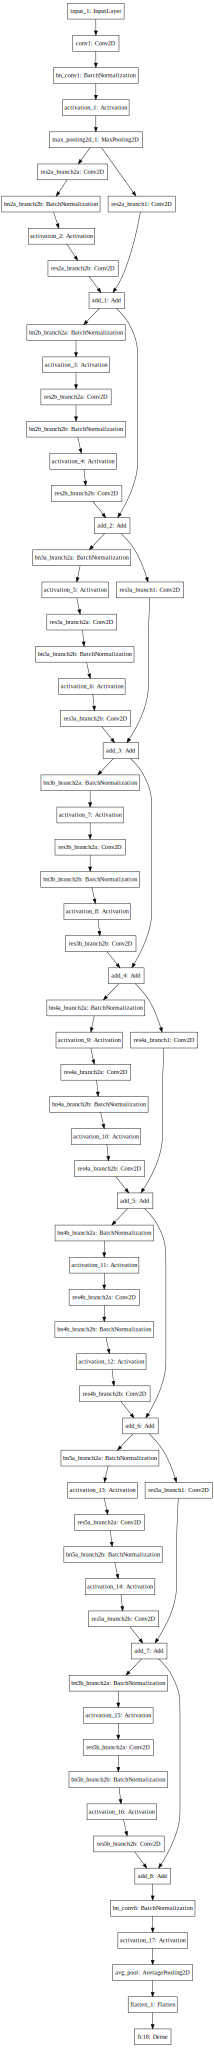

In [11]:
# plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))